# Automating backpropagation

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

def trace(root):
    # recursively builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes: 
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n_i to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

## 1. Implement `_backward()` (backprop) for each operation in `Value` class

* First, create a `_backward` function to do the chain rule at each node (default `None`, e.g. at leaf nodes, nothing to do)
* More specifically, we're propagating the the output gradient of a node (`out.grad`)
    * into its children's gradients! (`self.grad` and `other.grad` attributes).
* Note the single underscore character at the start of the `_backward()` *method name* (and also the `_prev` and `_op` *attribute names*) are a convention (not enforced in Python language!)
    * It simply means those methods/attributes are intended for **internal use within the class only** (i.e. it's a private method/attribute)

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # a function to do the chain rule at each node (default, do nothing (e.g. at leaf node))
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            '''uses the CHAIN RULE to propagate the gradient of '+' (addition) node's output 
            "backwards" into the children nodes' gradients
            '''
            self.grad = out.grad * 1.0 # for addition operation, gradient is simply copied backwards to child node 1
            other.grad = out.grad * 1.0 # and same for child node 2
            
        out._backward = _backward # save the WHOLE _backward() FUNCTION as a variable (instead of calling it)
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            '''uses the CHAIN RULE to propagate the gradient of '*' (multiplication) node's output 
            "backwards" into the children nodes' gradients
            '''
            self.grad = out.grad * other.data # for multiplication operation, gradient is the 
            other.grad = out.grad * self.data # and same for child node 2
            
        out._backward = _backward
        
        return out

    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            '''uses the CHAIN RULE to propagate the gradient of 'tanh' node's output 
            "backwards" into the (single) child node's gradient
            '''
            self.grad = (1 - t**2) * out.grad # local derivative of tanh (according to wikipedia). Needs more explaining
            
        out._backward = _backward
        
        return out

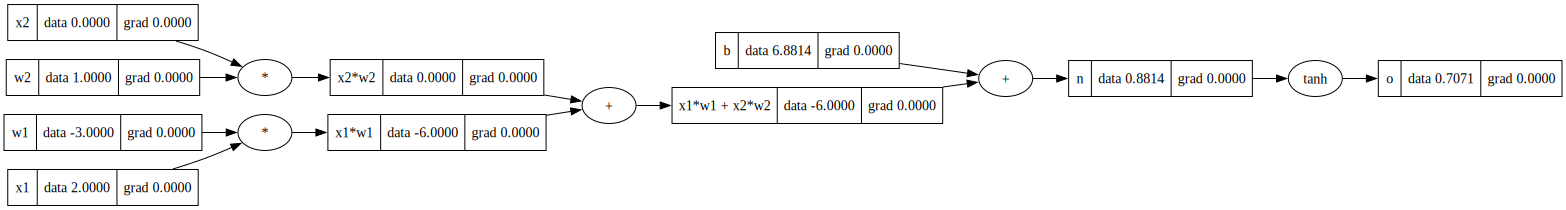

In [4]:
# redefine inputs (x1,x2), weights (w1,w2), and then the graph (n = x1*w1 + x2*w2 + b)
x1 = Value(2.0, label='x1'); x2 = Value(0.0, label='x2'); w1 = Value(-3.0, label='w1'); w2 = Value(1.0, label='w2')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'; x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# manually change bias to make number nice for education: (b=8 to see tanh squishing!, b=6.8813735870195432 so deriv = 1)
b = Value(6.8813735870195432, label='b')
n = x1w1x2w2 + b; n.label = 'n'

# try re-run the activation function on n (the raw cell body) and draw the output node o
o = n.tanh(); o.label = 'o'
draw_dot(o)

### 1.1. Call `_backward()` (backprop) one at a time for each node

* Initialise "global gradient" (do/do, i.e. `o.grad`) to 1 for the final node
* Call `._backward()` on the final node `o`

n.grad (before o._backward):  0.0
--> n.grad (after o._backward):  0.4999999999999999

x1w1x2w2.grad (before o._backward):  0.0 
b.grad (before o._backward):  0.0
--> x1w1x2w2.grad (after o._backward):  0.4999999999999999 
--> b.grad (after o._backward):  0.4999999999999999

x1w1.grad (before o._backward):  0.0 
x2w2.grad (before o._backward):  0.0
--> x1w1.grad (after o._backward):  0.4999999999999999 
--> x2w2.grad (after o._backward):  0.4999999999999999

x1.grad (before o._backward):  0.0 
w1.grad (before o._backward):  0.0 
x2.grad (before o._backward):  0.0 
w2.grad (before o._backward):  0.0
--> x1.grad (after o._backward):  -1.4999999999999996 
--> w1.grad (after o._backward):  0.9999999999999998 
--> x2.grad (after o._backward):  0.4999999999999999 
--> w2.grad (after o._backward):  0.0


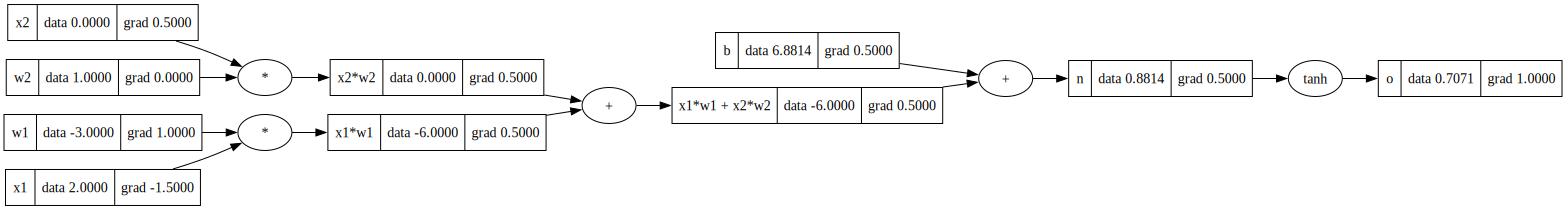

In [5]:
# Feel free to uncomment draw_dot(o) lines one at a time to see it propagate

o.grad = 1.0 # init global gradient for final node

print('n.grad (before o._backward): ', n.grad)
o._backward() # this will route o's gradient backward to n
print('--> n.grad (after o._backward): ', n.grad)
# draw_dot(o) # voila! check n.grad

print('\nx1w1x2w2.grad (before o._backward): ', x1w1x2w2.grad, '\nb.grad (before o._backward): ', b.grad)
n._backward() # this will route n's gradient backward to its children, b and x1w1x2w2
print('--> x1w1x2w2.grad (after o._backward): ', x1w1x2w2.grad, '\n--> b.grad (after o._backward): ', b.grad)
# draw_dot(o) # voila! check b.grad and x1w1x2w2.grad

b._backward() # by initialisation b's _backward the lambda:None (empty function); nothing happens!
# draw_dot(o)

print('\nx1w1.grad (before o._backward): ', x1w1.grad, '\nx2w2.grad (before o._backward): ', x2w2.grad)
x1w1x2w2._backward()
print('--> x1w1.grad (after o._backward): ', x1w1.grad, '\n--> x2w2.grad (after o._backward): ', x2w2.grad)
# draw_dot(o)

print('\nx1.grad (before o._backward): ', x1.grad, '\nw1.grad (before o._backward): ', w1.grad, '\nx2.grad (before o._backward): ', x2.grad, '\nw2.grad (before o._backward): ', w2.grad)
x1w1._backward()
x2w2._backward()
print('--> x1.grad (after o._backward): ', x1.grad, '\n--> w1.grad (after o._backward): ', w1.grad, '\n--> x2.grad (after o._backward): ', x2.grad, '\n--> w2.grad (after o._backward): ', w2.grad)

draw_dot(o)

## 2. Implement `_backward()` function for a whole expression graph

* I.e. no need to call `_backward()` for each node individually.
* Instead, simply ensure that *a given node's* gradient has been calculated before calling `._backward()` on that node
    * Thereby ensuring all dependencies (gradients) are evaluated, **before** we try to propagate the network **further backwards** to "more" prior (input) nodes.
 
Use topological sort to lay out a directed acyclical graph (DAG) in such a way that all edges go from L to R:

<div>
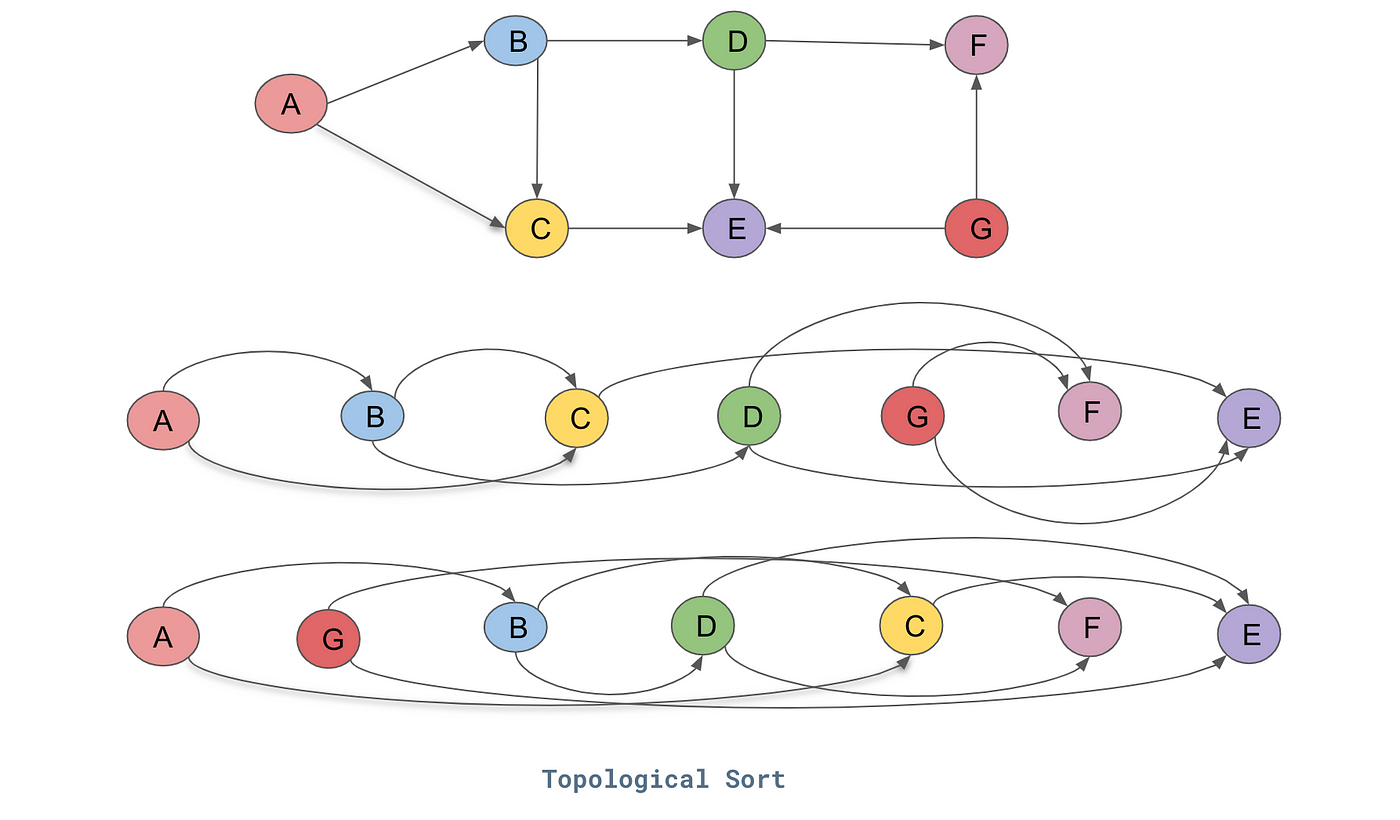
</div>


In [6]:
# build a topological graph
topo = [] # this list is a global variable
visited = set() # maintain set of visited nodes (global variable)

def build_topo(v):
    '''
    given a root node, v, this function recursively lays the child nodes of v from Left-to-Right
    this ensuring all arcs point in one direction

    Inputs:
        v: root node

    Returns:
        None: global variable 'topo' is now a sorted list of nodes
    '''
    if v not in visited:
        visited.add(v) # add node to the list, if we have not yet visited it
        for child in v._prev:
            build_topo(child) # recursively call
        topo.append(v) # a node only adds itself to the 'topo' global list AFTER all its CHILDREN have been added.

build_topo(o) # start the topo sort at node `o` (the root node)
topo # note: this (global) list is now topo sorted!

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

reset_graph(): All gradients have been reset to 0


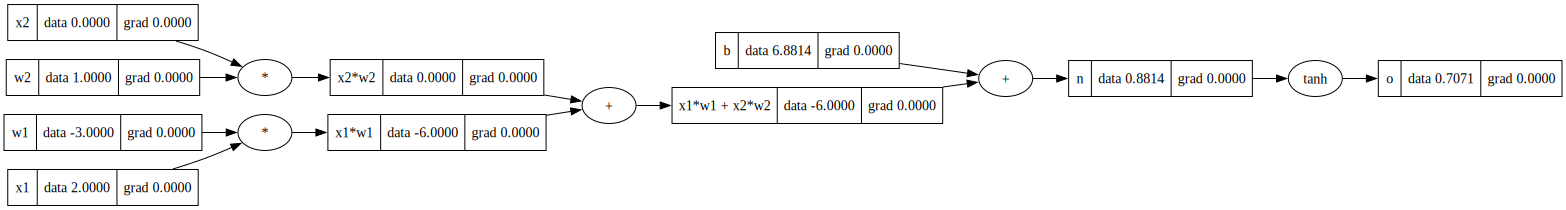

In [7]:
def reset_graph(reset_level):
    
    # declare global gradients
    global x1, x2, w1, w2, x1w1, x2w2, x1w1x2w2, b, n, o

    if reset_level == 'gradients':
        x1.grad = x2.grad = w1.grad = w2.grad = x1w1.grad = x2w2.grad = x1w1x2w2.grad = b.grad = n.grad = o.grad = 0

        print("reset_graph(): All gradients have been reset to 0")

    elif reset_level == 'graph':
        # reset all variables
        x1 = Value(2.0, label='x1'); x2 = Value(0.0, label='x2'); w1 = Value(-3.0, label='w1'); w2 = Value(1.0, label='w2')
        x1w1 = x1 * w1; x1w1.label = 'x1*w1'; x2w2 = x2 * w2; x2w2.label = 'x2*w2'; x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
        b = Value(6.8813735870195432, label='b'); n = x1w1x2w2 + b; n.label = 'n'; o = n.tanh(); o.label = 'o'
    
        print("reset_graph(): All vars, initial and intermediate, have been reset. All gradients now 0")

    else: print("reset_graph(): please specify the level of reset desired 'gradients' or 'graph'")


reset_graph('gradients') # reset all gradients to 0
draw_dot(o)

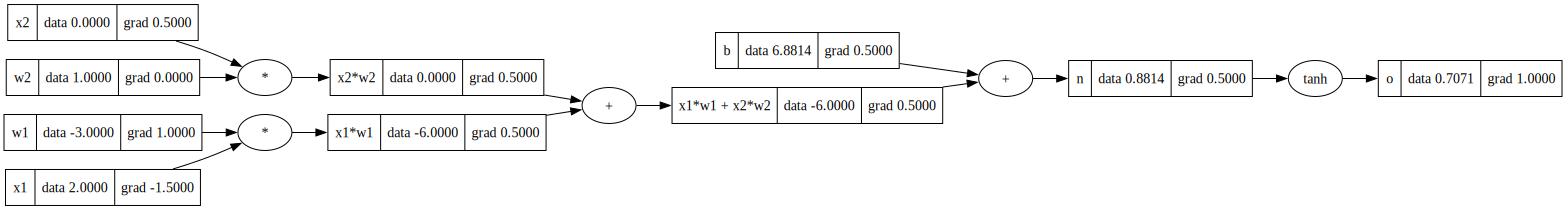

In [8]:
# initialise "global gradient" for final node
o.grad = 1.0

# now call ._backward() on all nodes in reversed topological order (starting at the final node, `o`)
for node in reversed(topo):
    node._backward()

draw_dot(o)

### 2.1. Define a dedicated `backward()` function for the whole expression graph (in `Value`)

Move our topo logic into `Value`:

In [9]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # NB init bc ._backward() is uniquely defined and called in the '+', '*' and 'tanh' operations
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = out.grad * 1.0
            other.grad = out.grad * 1.0
            
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
            
        out._backward = _backward
        
        return out

    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out

    def backward(self):
        '''
        this function is intended to be called once on the FINAL node (thus self = o, upon global function call)
        function call: o.backward()
        '''
        topo = [] # list is now local to this backward() function's scope
        visited = set() # now local to this backward() function's scope
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # from build_topo() POV, "topo" list is "global". However, "topo" scope is limited to the backward() function only.
        build_topo(self)
        
        self.grad = 1.0 # initialise the current node's gradient to 1.0
        for node in reversed(topo): # i.e. starting at the current node, and going backwards to its children
            node._backward()

reset_graph(): All vars, initial and intermediate, have been reset. All gradients now 0


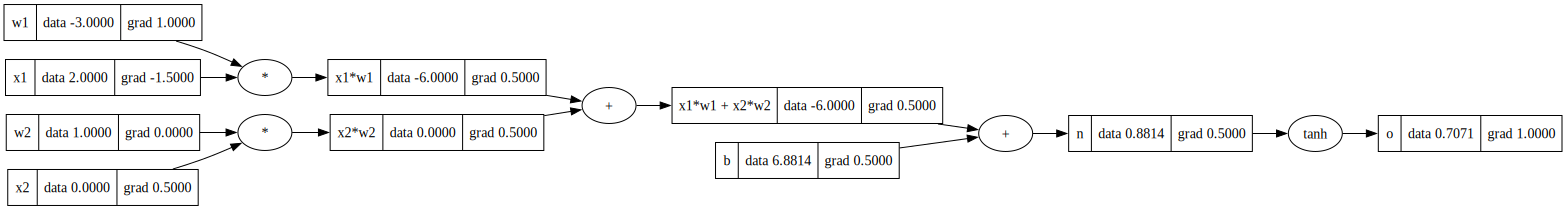

In [10]:
reset_graph('graph') # this works because we have already redefined the Value object!
o.backward()
draw_dot(o)

### 3. There is a bug with `_backward()`:

See the following 2 examples

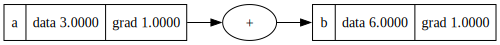

In [11]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

There are actually 2 `a` nodes (two arrows). The gradients are wrong! Note:

$$ 
\begin{align}
b &= a + a \\
&= 2a \\ \\
\therefore \frac{\mathrm{d}b}{\mathrm{d}a} &= 2 \\
\end{align}
$$

So clearly `a.grad = 1` is wrong


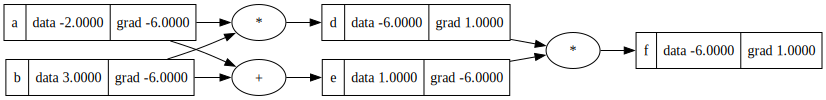

In [12]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

#### Firstly recall (local gradients):

$$ 
\text{since } f = d \times e \implies \frac{\mathrm{d}f}{\mathrm{d}d} = e \quad\text{and}\quad \frac{\mathrm{d}f}{\mathrm{d}e} = d
$$

So far so good; inspecting the graph shows `d.grad = 1.0 = e.data` and `e.grad = -6.0 = d.data`.

Now, for application of the chain rule (below), we need to be aware of the following intermediate derivatives:

$$ 
\begin{align}
\text{since } \quad d = a \times b \implies \frac{\mathrm{d}d}{\mathrm{d}a} = b \quad&\text{and}\quad \frac{\mathrm{d}d}{\mathrm{d}b} = a \\ \\
\text{and since } \quad e = a + b \implies \frac{\mathrm{d}e}{\mathrm{d}a} = 1 \quad&\text{and}\quad \frac{\mathrm{d}e}{\mathrm{d}b} = 1
\end{align}
$$

---

#### Error (hint: the following equations are the multivariate application of the chain rule):

However, the error arises because nodes `a` affects `f` **TWICE**... First through node `d` **AND again** through node `e`. 

To demonstrate the error, let's find $\frac{\mathrm{d}f}{\mathrm{d}a}$:

$$
\begin{align}
\frac{\mathrm{d}f}{\mathrm{d}a} &= \frac{\mathrm{d}f}{\mathrm{d}d} \cdot \frac{\mathrm{d}d}{\mathrm{d}a} + \frac{\mathrm{d}f}{\mathrm{d}e} \cdot \frac{\mathrm{d}e}{\mathrm{d}a} \\ \\
&= e \cdot b + d \cdot 1 \\ \\
&= 1.0 \cdot 3.0 + (-6.0) \cdot 1 = -3.0
\end{align}
$$

Yet, upon inspecting the graph, we see `a.grad = -6.0` which does not equal our proven derivative $\frac{\mathrm{d}f}{\mathrm{d}a} = -3.0$ above

And similarly, if we find $\frac{\mathrm{d}f}{\mathrm{d}b}$:

$$
\begin{align}
\frac{\mathrm{d}f}{\mathrm{d}b} &= \frac{\mathrm{d}f}{\mathrm{d}d} \cdot \frac{\mathrm{d}d}{\mathrm{d}b} + \frac{\mathrm{d}f}{\mathrm{d}e} \cdot \frac{\mathrm{d}e}{\mathrm{d}b} \\ \\
&= e \cdot a + d \cdot 1 \\ \\
&= 1.0 \cdot (-2.0) + (-6.0) \cdot 1 = -8.0
\end{align}
$$

Again, upon inspecting the graph, we see `b.grad = -6.0` which does not equal our proven derivative $\frac{\mathrm{d}f}{\mathrm{d}b} = -8.0$ above

---

#### Why is this error occuring?

* We are using the nodes (variables) `a` and `b` **more than once**.
* This is because we are **OVERWRITING** our gradient when we call `_backward()` a second time:

Take $\frac{\mathrm{d}f}{\mathrm{d}a}$ (i.e. finding `a.grad`; the effect of node `a` on `f`)
* First `_backward()` call (inside `__add__()` method) evaluates $\frac{\mathrm{d}f}{\mathrm{d}d} \cdot \frac{\mathrm{d}d}{\mathrm{d}a} = e \cdot b = 1 \cdot 3 = 3$
* Then, `_backward()` is called **a second time** (inside `__add()__`) to evaluate $\frac{\mathrm{d}f}{\mathrm{d}e} \cdot \frac{\mathrm{d}e}{\mathrm{d}a} = (-6) \cdot 1 = -6$
* This second call **overwrites** the $3$ value with $-6$ (instead of accumulating them together per multivariate chain rule)
    * The overwrite can happen vice versa, depends on which term is evaluated last

Again, for $\frac{\mathrm{d}f}{\mathrm{d}b}$ (i.e. finding `b.grad`; the effect of node `b` on `f`)
* First `_backward()` call (inside `__mul__()` method) evaluates $\frac{\mathrm{d}f}{\mathrm{d}d} \cdot \frac{\mathrm{d}d}{\mathrm{d}b} = e \cdot a = 1 \cdot (-2) = -2$
* Then, `_backward()` is called **a second time** (inside `__mul__()`) to evaluate $\frac{\mathrm{d}f}{\mathrm{d}e} \cdot \frac{\mathrm{d}e}{\mathrm{d}b} = (-6) \cdot 1 = -6$
* Again, second call **overwrites** the $-2$ value with $-6$ (instead of accumulating them together per multivariate chain rule)
    * The overwrite can happen vice versa, depends on which term is evaluated last 

#### TL;DR error fix and implementation (redefine `Value`)

For the multivariate case of the chain rule, we need to **accumulate** the gradients, instead of **overwriting** them!

In [13]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # initialising gradients to 0 allows us to accumulate (+=) then when using multivar chain rule case
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # accumulate the gradients (+=) bc multivar chain rule (i.e. a node influences the final node MORE THAN ONCE)
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
            
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # accumulate the gradients (+=) bc multivar chain rule (i.e. a node influences the final node MORE THAN ONCE)
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            
        out._backward = _backward
        
        return out

    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # accumulate the gradients (+=) bc multivar chain rule (i.e. a node influences the final node MORE THAN ONCE)
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

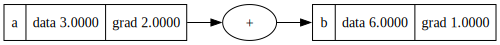

In [14]:
# reset example 1
a = Value(3.0, label='a'); b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

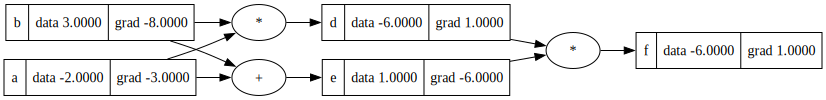

In [15]:
# reset example 2
a = Value(-2.0, label='a'); b = Value(3.0, label='b'); d = a * b; d.label = 'd'; e = a + b; e.label = 'e'; f = d * e; f.label = 'f'
f.backward()
draw_dot(f)